In [42]:
import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_val_score

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [9]:
df = pd.read_csv('../data/train.csv')

In [10]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


## Data Pre Processing

In [11]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', ' ', text)
    text = re.sub('\w*\d\w*', '', text)
    
    return text

In [12]:
df['comment_text'][0]

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [13]:
clean_text(df['comment_text'][0])

'explanation why the edits made under my username hardcore metallica fan were reverted they werent vandalisms just closure on some gas after i voted at new york dolls fac and please dont remove the template from the talk page since im retired '

In [14]:
df['comment_text'] = df['comment_text'].apply(clean_text)

### Replacing Emojies

In [16]:
import emoji

In [17]:
def use_emoji(text):

    text=emoji.demojize(str(text))
    text=re.sub(':','',text)
    text=re.sub(r'\:(.*?)\:','',text)
    
    return text

In [18]:
df['comment_text'] = df['comment_text'].apply(use_emoji)

### Removing Accents

In [19]:
import unicodedata

def remove_accents(input_str):
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    only_ascii = nfkd_form.encode('ASCII', 'ignore')
    only_ascii=re.sub(' +', ' ',(only_ascii.decode('utf-8')))
    return only_ascii

df['comment_text'] = df['comment_text'].apply(remove_accents)

In [20]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,explanation why the edits made under my userna...,0,0,0,0,0,0
1,000103f0d9cfb60f,daww he matches this background colour im seem...,0,0,0,0,0,0
2,000113f07ec002fd,hey man im really not trying to edit war its j...,0,0,0,0,0,0
3,0001b41b1c6bb37e,more i cant make any real suggestions on impr...,0,0,0,0,0,0
4,0001d958c54c6e35,you sir are my hero any chance you remember wh...,0,0,0,0,0,0


## To find y values for converting problem into Binary

In [21]:
df_new = df.sum(axis=1,numeric_only=True)
y = df_new.values

y[y > 0] = 1
np.unique(y,return_counts=True)

(array([0, 1], dtype=int64), array([143346,  16225], dtype=int64))

In [27]:
x = df['comment_text'].values

## Converting Text to Vector

In [28]:
#TFIDF APPROACH
vector = TfidfVectorizer(ngram_range=(1, 1), analyzer='word',strip_accents='unicode', use_idf=1, min_df=10)
x = vector.fit_transform(x)

In [29]:
x.shape,y.shape

((159571, 22243), (159571,))

In [31]:
#DocVec Approach
EMBEDDING_FILE = '../data/glove.twitter.27B.100d.txt'

embeddings_dictionary = dict()

glove_file = open(EMBEDDING_FILE, encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

In [34]:
comments = df['comment_text'].values

In [35]:
my_stopwords = stopwords.words('english')
vectorizer2 = TfidfVectorizer(stop_words = my_stopwords)
bag_of_words = vectorizer2.fit_transform(comments)

In [36]:
embeds = []
zeros_embed = 100*[0]
for key,val in sorted(vectorizer2.vocabulary_.items(), key = lambda kv:(kv[1], kv[0])):
# vectorizer.vocabulary_.keys():
    if key in embeddings_dictionary:
        embeds.append(embeddings_dictionary[key])
    else:
        embeds.append(zeros_embed)

In [37]:
import scipy.sparse as sparse
my_embeddings = sparse.csr_matrix(embeds)

In [38]:
doc_embeds = bag_of_words.dot(my_embeddings)

In [39]:
doc_embeds.shape

(159571, 100)

## Modelling

Now that we have vectors using both approaches (TFIDF and DocVecs), let's try diiferent classification models and compare their performance. We will use 5-fold CV for comparison

In [40]:
mnb = MultinomialNB()
lr = LogisticRegression(max_iter=5000)
lsvc = LinearSVC(max_iter=5000)

models = [mnb,lr,lsvc]

In [43]:
f1_results = []
for model in models:
    f1 = cross_val_score(model, x,y, cv=5, scoring='f1_weighted')
    f1_results.append(f1.mean())

In [44]:
names = ['MNB_TF','LR_TF','LSVC_TF']

names,f1_results

(['MNB_TF', 'LR_TF', 'LSVC_TF'],
 [0.9338382994080643, 0.9519530411339799, 0.9590698713465743])

In [46]:
lr2 = LogisticRegression(max_iter=5000)
lsvc2 = LinearSVC(max_iter=5000)
dt = DecisionTreeClassifier(max_depth=25)
rf = RandomForestClassifier(max_depth=15, n_estimators=40)

models2 = [lr2,lsvc2,dt,rf]

In [49]:
for model in models2:
    f1 = cross_val_score(model, doc_embeds,y, cv=5, scoring='f1_weighted')
    f1_results.append(f1.mean())

In [54]:
names = ['MNB_TF','LR_TF','LSVC_TF','LR_DE','LSVC_DE','DT_DE','RF_DE']

names,f1_results

(['MNB_TF', 'LR_TF', 'LSVC_TF', 'LR_DE', 'LSVC_DE', 'DT_DE', 'RF_DE'],
 [0.9338382994080643,
  0.9519530411339799,
  0.9590698713465743,
  0.9409226575260486,
  0.9394440316037507,
  0.8999677012231105,
  0.926327251949196])

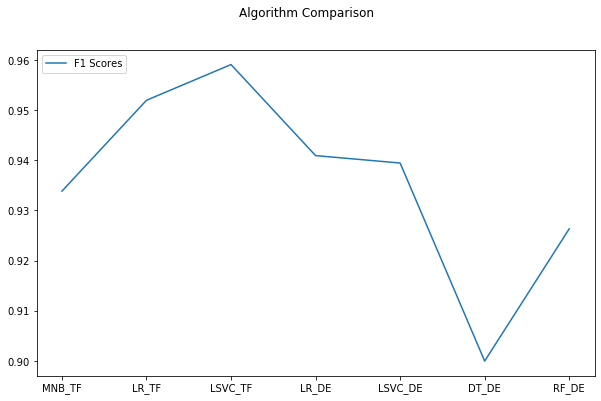

In [55]:
fig = plt.figure(figsize=(10,6))
fig.suptitle('Algorithm Comparison')

ax = fig.add_subplot(111)
# plt.plot(recall_mean)
plt.plot(f1_results)
ax.set_xticks([0,1,2,3,4,5,6])
ax.set_xticklabels(names)
plt.legend(['F1 Scores'],loc='upper left')
# plt.savefig(fname='algo comp edu presentation',dpi=1200)
plt.show()